In [9]:
import jax.experimental.optimizers as optimizers
import jax.numpy as np
import jax.random as jr
import matplotlib.pyplot as plt
from jax import jit, value_and_grad, vmap
from matplotlib.gridspec import GridSpec
from ssm.distributions.glm import GaussianGLM, PoissonGLM
from ssm.distributions.linreg import GaussianLinearRegression
from ssm.models.lds import LDS, GaussianLDS
from ssm.plots import plot_dynamics_2d
from ssm.utils import random_rotation
from tensorflow_probability.substrates import jax as tfp
from tqdm.auto import trange
import warnings

def create_random_plds(emissions_dim=10, latent_dim=2, rng=jr.PRNGKey(0)):
    key1, key2 = jr.split(rng, 2)
    
    initial_distribution = tfp.distributions.MultivariateNormalTriL(
        np.zeros(latent_dim), np.eye(latent_dim))

    dynamics_distribution = GaussianLinearRegression(
        random_rotation(key1, latent_dim, theta=np.pi/20),
        np.zeros(latent_dim), 
        0.1**2 * np.eye(latent_dim))

    emissions_distribution = PoissonGLM(
        jr.normal(key2, shape=(emissions_dim, latent_dim)), 
        np.ones(emissions_dim))

    # Initialize our true Poisson LDS model
    lds = LDS(initial_distribution, 
                dynamics_distribution,
                emissions_distribution)
    
    return lds

def sample_plds(lds, num_trials=5, time_bins=200, rng=jr.PRNGKey(0)):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        all_states, all_data = lds.sample(key=rng, num_steps=time_bins, num_samples=num_trials)
    return all_states, all_data

from time import time
def timer(func):
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        t_elapsed = t2-t1
        print(f'Function {func.__name__!r} executed in {t_elapsed:.4f}s')
        return result, t_elapsed
    return wrap_func

def prep_laplace_em_test(emission_dim=10, latent_dim=2, num_trials=5, time_bins=200, rng=jr.PRNGKey(0)):
    true_rng, sample_rng, test_rng = jr.split(rng, 3)

    # create and sample from true_lds
    true_lds = create_random_plds(emission_dim, latent_dim, rng=true_rng)
    states, data = sample_plds(true_lds, num_trials, time_bins, rng=sample_rng)
    
    # create test_lds and fit
    test_lds = create_random_plds(emission_dim, latent_dim, rng=test_rng)
    return true_lds, test_lds, states, data

def time_laplace_em(emission_dim=10, latent_dim=2, num_trials=5, time_bins=200, rng=jr.PRNGKey(0)):
    rng_prep, rng_fit = jr.split(rng, 2)
    true_lds, test_lds, states, data = prep_laplace_em_test(emission_dim, latent_dim, num_trials, time_bins, rng_prep)
    (elbos, fitted_lds, posteriors), fit_time = timer(test_lds.fit)(data, method="laplace_em", rng=rng_fit)
    return (elbos, fitted_lds, posteriors), fit_time

In [ ]:
from tqdm.auto import trange

times = dict()
for i in trange(0, 31, 5):
    if i == 0: i += 1
    _, elapsed_time = time_laplace_em(num_trials=i)
    times[i] = elapsed_time

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

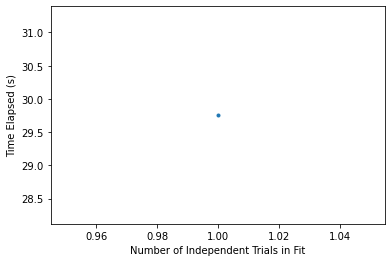

In [8]:
x = list(times.keys())
y = list(times.values())
out = np.array([x, y])

np.save("../data/ssm_jax/laplace_em_num_trials.npz", out)
out_from_file = np.load("../data/ssm_jax/laplace_em_num_trials.npy")
plt.plot(*out_from_file, '.-')
plt.xlabel("Number of Independent Trials in Fit")
plt.ylabel("Time Elapsed (s)")
plt.show()